<a href="https://colab.research.google.com/github/Soham-Kamat/Soham/blob/master/NetflixMovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 308kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617610 sha256=37f573517d54c1f05814238695f765f99cf42f81635ff6b33e4f325480667850
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [8]:
# Skip date
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::100000, :])

Dataset 1 shape: (764404, 2)
-Dataset examples-
        Cust_Id  Rating
0            1:     NaN
100000  1732588     4.0
200000  1842450     5.0
300000  2503038     2.0
400000  2544428     4.0
500000   983686     3.0
600000  1476719     4.0
700000   215052     1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
# load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::100000, :])



Full dataset shape: (764404, 2)
-Dataset examples-
        Cust_Id  Rating
0            1:     NaN
100000  1732588     4.0
200000  1842450     5.0
300000  2503038     2.0
400000  2544428     4.0
500000   983686     3.0
600000  1476719     4.0
700000   215052     1.0


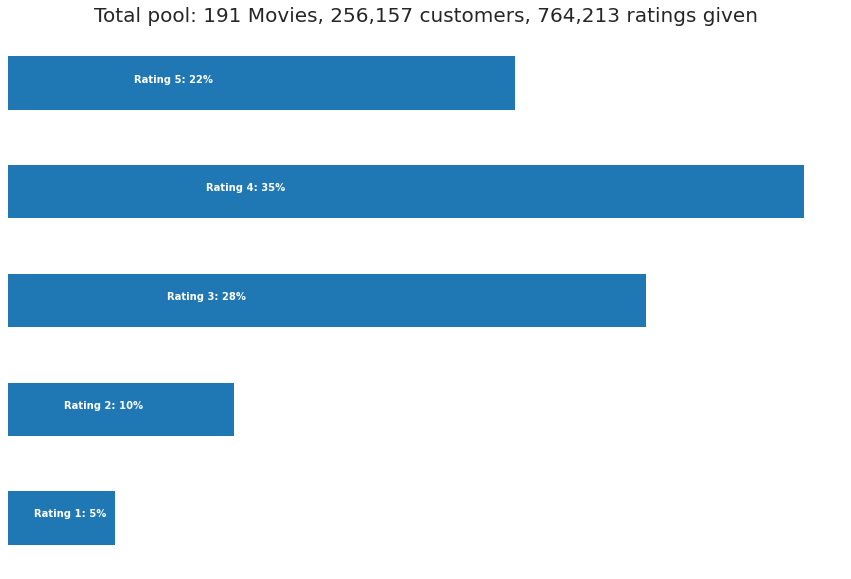

In [10]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [11]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [  1.   1.   1. ... 191. 191. 191.]
Length: 764213


In [12]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


-Dataset examples-
   Cust_Id  Rating  Movie_Id
1  1488844     3.0         1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1393.0
Customer minimum times of review: 3.0


In [14]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (764213, 3)
After Trim Shape: (514781, 3)
-Data Examples-
     Cust_Id  Rating  Movie_Id
696   712664     5.0         3


In [15]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)


(101553, 58)


In [18]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(20))



            Year                                               Name
Movie_Id                                                           
1         2003.0                                    Dinosaur Planet
2         2004.0                         Isle of Man TT 2004 Review
3         1997.0                                          Character
4         1994.0                       Paula Abdul's Get Up & Dance
5         2004.0                           The Rise and Fall of ECW
6         1997.0                                               Sick
7         1992.0                                              8 Man
8         2004.0                         What the #$*! Do We Know!?
9         1991.0                           Class of Nuke 'Em High 2
10        2001.0                                            Fighter
11        1999.0                     Full Frame: Documentary Shorts
12        1947.0                               My Favorite Brunette
13        2003.0  Lord of the Rings: The Return 

In [27]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])


{'fit_time': (25.414397954940796,
  25.52954363822937,
  25.476566791534424,
  25.61899209022522,
  25.588969707489014),
 'test_mae': array([0.77371047, 0.7713555 , 0.76762209, 0.77301953, 0.77176745]),
 'test_rmse': array([0.98128853, 0.98045997, 0.98004421, 0.98253864, 0.98121903]),
 'test_time': (1.4166405200958252,
  0.9189319610595703,
  1.2941420078277588,
  1.2178409099578857,
  1.339418649673462)}

In [28]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)



Movie_Id
57        Richard III
175    Reservoir Dogs
Name: Name, dtype: object


In [29]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))


       Year                                               Name  Estimate_Score
56   1995.0                                        Richard III        3.753488
32   2000.0                     Aqua Teen Hunger Force: Vol. 1        3.618982
174  1992.0                                     Reservoir Dogs        3.548345
45   1964.0                     Rudolph the Red-Nosed Reindeer        3.470038
132  2003.0                              Viva La Bam: Season 1        3.441781
137  1995.0                       Star Trek: Voyager: Season 1        3.434808
55   2004.0                                          Carandiru        3.425795
166  2004.0                                         The Chorus        3.404887
31   2004.0  ABC Primetime: Mel Gibson's The Passion of the...        3.402416
190  2003.0                                   X2: X-Men United        3.358532


In [22]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [23]:

recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                             Name  count      mean
 1.000000       What the #$*! Do We Know!?  14910  3.189805
 0.402254  Maya Lin: A Strong Clear Vision   1561  3.770019
 0.345106                      Invader Zim   2216  4.142599
 0.343935                        Carandiru   1833  3.648663
 0.335711                     Regular Guys   1931  3.372864
 0.306887                          Scratch   2418  3.833747
 0.299101                  The Love Letter   2619  2.968690
 0.288932                             Jade   2406  3.024522
 0.273619   Bruce Lee: A Warrior's Journey   1393  3.885140
 0.268316                        Character   2012  3.641153
